<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Natural Language Generation</div>

In this exercice, we will try out the approach of Natural Language Generation, using a Seq2Seq (sequence to sequence) architecture.

This notebook is a variant of the 3rd notebook on Natural Language Generation, using pyTorch instead of Keras/TF.
It is an adaptation of the excellent pyTorch tutorial on Seq2Seq approaches.

Natural Language Generation has often used approaches close to "fill-in-the-blanks" templates. 
Seq2Seq Encoder-Decoder architectures make the issue of Natural Language Generation different, especially in the case of language translation.

The approach is the following :
1. A LSTM network encodes the input sequence into state vectors, with a predefined dimensionality
2. A decoder LSTM predicts the next token of a target sequence based on the beginning o the sequence. The initial state is given by the encoder.

The approach used here to train a system that predicts the next token based on the beginning of the sequence is called Teacher Forcing

# 1. Parameters of the experiment

In this example, we will train a system that translates basic english sentences into french. The data used for this example is a list of French sentences and their translation into english.

# 1. Teacher forcing

## 1.a Example

Say we work with the following sequence :

```
Rien ne sert de courir il faut partir à point
```

We want to train a model that predicts the following word of the sequence based on the start of it. First, in order for the first word of the sequence and the end of it to be predicted, we need to add beginning and end tokens to the sequence. We decide to use \t as the beginning token, and \n as the end one :

```
\t Rien ne sert de courir il faut partir à point \n
```

When training the system, we start by inputing the "\t" beginning token:

```
input: 
\t
prediction:
sert
```

The untrained model generated "sert" where we expected "Mary". There are now two options to continue :

### Without forcing :

We add the previous output, "sert", to the input sequence, and continue generating :

```
input: 
\t sert
```

With this approach, the error will propagate and make the model much slower to learn. 

### With teacher forcing

After computing error, we discard the output "sert", and replace it with the word that was actually expected ("Rien"). This is called *teacher forcing* :

```
input: 
\t Rien
```

Using his technique provides much faster training of the model. However, please note that it can also be a source of instability on previously unseen data.

# 2. Importing data


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

hidden_size = 256  # Latent dimensionality of the encoding space.

# Path to the data
data_path = 'datasets/enfratexts.txt'

#setting up device for use with pyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device used is ",device)

device used is  cpu


## 2.1 Utils to import and preprocess data

We vectorize the data using words as features. 

This means that we will first define a vocabulary containing all the words in our corpus (simalr to what we did in notebook 1 for BOW and TFIDF calculation). The sequences will then be vectorized as a sequence of ints, corresponding to the id a given word in the dictionnary.

This section defines a set of utilities to import data :
- A class defining the characteristics of the languages imported (french and english), including the size of the vocabulary and the dictionnary mapping words to indexes.
- Methods to import data, including a simple preprocessing that lowercases all the characters and removes special characters, in order to control the size of our dictionnay (see notebook 1). 
- Methods to select data from our dataset, useful for running iterations of our network.

Please note that contrary to what we did for classification, the preprocessing does not include Lemmatization or Stemming. This is logical, considering we need to keep data readable by a human. 
And also don't forget that we are using two special characters "1" for start of sequence and "0" for end of sequence.

In [8]:
# Start and end sequence tokens
Start_sentence_token = 1
End_sentence_token = 0


#Class defining a language.
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}#Contains the index of each word in the dictionnary
        self.word2count = {}#Contains the count of each word
        self.index2word = {1: "SOS", 0: "EOS"} #Reverse lookup table for words (useful for decoding sentences back to a readable form)
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
## UTILS
import re, unicodedata

# Convert to ASCII (because of french sentences)
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Trim, lowercase sentences and remove special chracters except punctuation
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# Filter data to keep only some relevant pairs. In particular, to ensure that the system trains fast enough,
# we define a max length for sequences and keep only sentences sentences that start the same.
max_length = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < max_length and len(p[1].split(' ')) < max_length and p[0].startswith(eng_prefixes)
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


# Reading, Normalizing data
def readLangs(lang1, lang2):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(data_path, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Create language objects
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs



# Full pipeline for importing data :
# Reads the files, and cleans data
# Filters pairs of english/french sentences to keep only those that are short enough and start the same
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Filtered to %s sentence pairs" % len(pairs))
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Dictionnary size:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

## 2.2 Import and prepare data

In [9]:
import random

input_lang, output_lang, pairs = prepareData('english', 'francais')

Reading lines...
Read 170651 sentence pairs
Filtered to 12761 sentence pairs
Dictionnary size:
english 3054
francais 4740


# 3. Vectorizing the data



In the previous section we defined a dictionnary to vectorize data in a BOW fashion. 

Vectorizing data for use by our Neural Network is performed through the folowing steps :
- Step 1 : using the dictionnary, the sequence of words is turned into a sequence of indexes
- Step 2 : we append the End of Sentence token. Then, the sequence of indexes is turned into a tensor for use by pyTorch. 

In [10]:
# STEP 1
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

# STEP 2
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(End_sentence_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# Performing the two steps of vectorization on a pair of english/french sequences
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# 3.0. Defining the Encoder-Decoder Architecture

## 3.1. Encoder

Encoding is performed via a LSTM, whose state we will store to condition the decoding. 
Inputs are first embedded into fixed dimensional space, and then encoded by the lstm. We also keep the hidden states of the lstm, as we need to feed them to the encoder for the next iteration.


In [11]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        
        self.hidden_size = hidden_size
        #Embedding Layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        #LSTM Layer
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        
        
    def forward(self, input, hidden):
        
        #Embedding the input
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        # We feed the embedded vector as well as the hidden states passed as argument into the lstm
        output, hidden = self.lstm(output, hidden)
        return output, hidden

## 3.2. Decoder

The decoder is meant to predict the next token of the target sentence, knowing the current token and the context vectors given by the encoder (hidden vectors).
The context vectors ancode the input sequence that was given, and will condition all the prediction of the decoder.

In [12]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        #Embedding Laeyr
        self.embedding = nn.Embedding(output_size, hidden_size)
        #LSTM Layer
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        #Linear layer mapping to the output size
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        
        #Embedding the input and applying relu
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        
        # We feed the embedded vector as well as the context vector passed as argument into the lstm
        output, hidden = self.lstm(output, hidden)
        # Softmax layer (probabilities of each token)
        output = self.softmax(self.out(output[0]))
        
        return output, hidden




# 4. Training the model

First, we write a function that defines one step of training the model :

In [13]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):
    
    #initialize hidden and cell state of the encoder lstm randomly
    encoder_hidden = torch.randn(1, 1, hidden_size)
    encoder_cell = torch.randn(1, 1, hidden_size)

    #zero out the gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    #Get length of input and target sequences
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0
    
    ## ENCODER
    #initialize the output of the encoder to zero
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    #We pass each input token to the encoder. At each step, we retrive the output and the hidden/cell states,
    #forming the context vector. The context vector is fed back to the encoder for the next step.
    for ei in range(input_length):
        encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei], (encoder_hidden,encoder_cell))
        encoder_outputs[ei] = encoder_output[0, 0]

    ## DECODER
    #For the decoder, the input is initialized with a Start of Sequence token
    decoder_input = torch.tensor([[Start_sentence_token]], device=device)

    #The decoder states are initialized by passing the context vector from the encoder
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    
    #We pass each target token to the decoder. We keep the hidden and cell states, that we will feed back to the
    #decoder for the next step. However, the outputs are discarded, and the next input of the decoder is the target
    #output (see teacher forcing above)
    for di in range(target_length):
        decoder_output, (decoder_hidden,decoder_cell) = decoder(decoder_input, (decoder_hidden,decoder_cell))
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

    #Backward prop
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    #Return loss
    return loss.item() / target_length

## 4.1 Plotting loss

We have setup the trainign function to return the current loss of the model. 
The function below displays the learning curve

In [14]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


## 4.2. Running multiple iterations

In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    
    plot_losses = [] #Will hold all losses for plotting
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    #Setup optimizers
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    #Prepare n_iter training data to run n-iter steps
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        
        # Retrieve the next tensors for input and target
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        #Run one step of training
        loss = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        #Every few steps, we print the current status of training. We also store the loss for plotting
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(iteration %d %d%%) loss = %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    #Plot learning curve at the end
    showPlot(plot_losses)


## 4.3. Application

(iteration 100 10%) loss = 6.5646
(iteration 200 20%) loss = 4.8739
(iteration 300 30%) loss = 4.4741
(iteration 400 40%) loss = 4.3644
(iteration 500 50%) loss = 4.1951
(iteration 600 60%) loss = 4.0346
(iteration 700 70%) loss = 3.8125
(iteration 800 80%) loss = 3.9134
(iteration 900 90%) loss = 3.7481
(iteration 1000 100%) loss = 3.7079


<Figure size 432x288 with 0 Axes>

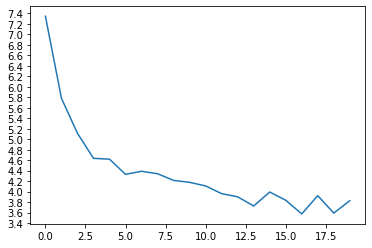

In [16]:
encoder = Encoder(input_lang.n_words, hidden_size).to(device)
decoder = Decoder(hidden_size, output_lang.n_words).to(device)

trainIters(encoder, decoder, 1000, print_every=100,plot_every=50)

## 4.4. Inference

For inference, the only difference with training is that we will continue to feed back the network's predictions to itself at each step, and stop only when we predict an end of sentence token.

In [21]:
def inference(encoder, decoder, sentence, max_length=max_length):
    
    with torch.no_grad(): #Freeze gradient
        
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        #Initialize the encoder hidden states
        encoder_hidden = torch.randn(1, 1, hidden_size)
        encoder_cell = torch.randn(1, 1, hidden_size)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        ##ENCODER
        for ei in range(input_length):
            encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei],
                                                     (encoder_hidden,encoder_cell))
            encoder_outputs[ei] += encoder_output[0, 0]

        #Initialize decoder input with a start of sentence token
        decoder_input = torch.tensor([[Start_sentence_token]], device=device) 

        #Feed the encoder context vectors to the decoder
        decoder_hidden = encoder_hidden
        decoder_cell=encoder_cell

        decoded_words = [] #Will hold the decoded sequence (translation)

        for di in range(max_length):
            decoder_output, (decoder_hidden,decoder_cell) = decoder(decoder_input, (decoder_hidden,decoder_cell))
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == End_sentence_token:
                decoded_words.append('<EOS>')
                break #Stop if we predict an end of sentence token
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach() #Use the previously predicted token as the input for the next step

        return decoded_words

We define a util function that will evaluate 10 random sentences from the train set and try to translate them

In [22]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = inference(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [23]:
evaluateRandomly(encoder, decoder)

> she s a beauty .
= c est une belle fille .
< je suis tres . <EOS>

> i am acting for my father .
= j agis pour mon pere .
< je suis tres . <EOS>

> she is almost as tall as you are .
= elle est presque aussi grande que toi .
< je suis tres . <EOS>

> he is a bad person .
= c est une mauvaise personne .
< je suis tres . <EOS>

> you re staying with tom right ?
= vous restez avec tom n est ce pas ?
< je suis pas en . <EOS>

> you re very timid .
= tu es fort craintive .
< je suis tres . <EOS>

> i m in good health .
= je suis en bonne sante .
< je suis tres . <EOS>

> i m looking for a sweater .
= je cherche un chandail .
< je suis tres . <EOS>

> i m not a specialist .
= je ne suis pas un specialiste .
< je suis tres . <EOS>

> she is as beautiful as a rose .
= elle est aussi belle qu une rose .
< je suis tres . <EOS>



After only a few trainin steps, we observe that translations are often all identical. It would take more several thousands of training iterations (probably about 100 000) to reach a somewhat satisfying result with this system. There are two main reasons that can explain this problem :

- First, the **use of teacher forcing**. Because we systematically correct the predictions of the network during training, the system has a tendency to learn to predict sentences that are grammatically correct, but would fail to learn the actual meaning. As an exercise, we could try to modfy the train function to not include teacher forcing. The flexibility of PyTorch also allows us to use teacher forcing sometimes, but not always.
- Then, the **architecture of the network**. Here, because the context vectors fed into the decoder are the same for a given input sentence, this means that the encoder has the responsibility to learn representations for the input sequence ***in its entirety***. For longer sentences, this isquite unefficient. In the rest of this notebook, we will introduce the notion of attention, as a response to this issue.

Next, We prepare the vectorized sequences. 

**Reminder : The decoder target data is the same as the input data, but ahead by one step.**

# 5. Using Attention

## 3.1. Encoder

Encoding is performed via a LSTM, whose state we will store to condition the decoding. The output is discarded, and we only keep the states (see teacher forcing explanation, earlier in this notebook).
Earlier in this notebook, we defined the latent dimensionnality of the encoder. 

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [15]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)



In [7]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## 3.2. Decoder

Decoding is performed through lstm and a softmax layer (used to predict character probabilities).
During inference, we will need to use the internal states of the decoder (see lower). We need to define the decoder accordingly 

In [8]:
# Prepare the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We define our decoder to return full output sequences, and to return internal states as well. We won't use the
# return states during trainging, but use them during inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


## 3.3 Full model

We define the model :
- using two inputs: the encoder inputs (french sentences) and decoder inputs (english sentences)
- returning the decoder outputs (english sentences ahead of one step)

Run a few epochs (50 only, and on 1000 documents, to save memory and time)

In [9]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 4. Training the Seq2Seq model

In this example, we propose to train on 80% of the data and test on 20% of the data. 
For processing time reasons, we propose to limit the size of training data as well as the number of epochs we run.

In [21]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=5,
          validation_split=0.2)
# Save model
model.save('nlg_encode_decode_model')

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 4s 6ms/step - loss: 0.9078 - accuracy: 0.7181 - val_loss: 1.8784 - val_accuracy: 0.4842
Epoch 2/5
800/800 [==============================] - 4s 4ms/step - loss: 0.8146 - accuracy: 0.7476 - val_loss: 1.9651 - val_accuracy: 0.4679
Epoch 3/5
800/800 [==============================] - 3s 4ms/step - loss: 0.8034 - accuracy: 0.7523 - val_loss: 2.0789 - val_accuracy: 0.4654
Epoch 4/5
800/800 [==============================] - 3s 4ms/step - loss: 0.7997 - accuracy: 0.7508 - val_loss: 1.9438 - val_accuracy: 0.4717
Epoch 5/5
800/800 [==============================] - 3s 4ms/step - loss: 0.7819 - accuracy: 0.7580 - val_loss: 1.8939 - val_accuracy: 0.4854


# 5. Inference

First, we need to define the models required to perform inference

1) encode input and retrieve initial decoder state
2) run one step of decoder with this initial state and a "start of sequence" token as target. Output will be the next target token
3) Repeat with the current target token and current states

In [43]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [122]:
evaluateRandomly(encoder1, attn_decoder1)

> she is french .
= elle est francaise .
< elle est est . <EOS>

> you re restless .
= tu es agitee .
< vous etes ! <EOS>

> you are lying .
= vous mentez .
< vous etes ! <EOS>

> you re blushing .
= tu rougis !
< vous etes ! <EOS>

> you re incorrigible .
= tu es incorrigible .
< vous etes ! <EOS>

> you re productive .
= vous etes productives .
< vous etes ! <EOS>

> you re skinny .
= vous etes maigrichon .
< vous etes ! <EOS>

> you re arrogant .
= tu es arrogante .
< vous etes ! <EOS>

> you re temperamental .
= vous etes lunatiques .
< vous etes ! <EOS>

> i m motivated .
= je suis motive .
< je suis malade . <EOS>



In [11]:

# 1.Define encoder model transforming the encoder input into the states of the encoding LSTM
encoder_model = Model(encoder_inputs, encoder_states)

# 2.Define decoder : the initial states of the decoder are also an input of the model (input from the encoder)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# Decoder LSTM
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
# Decode softmax layer
decoder_outputs = decoder_dense(decoder_outputs)
# Full decoder model : 
# - it takes the decoder inputs (english sequences) as well as the initial states as inputs
# - it returns the decoder outputs (english sequence ahead by one step) and the current states (that will be used for the next inference step)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

We then write a function that will perform decoding. The steps for decoding are the following :
- We encode the input sequence, and retrieve the states (step 1 in the cell above)
- We run one step of the decoder, using the initial state retrieved from the encoder, and a sequence containing only a start of sequence token "\t". 
- From this step, we retrieve the output sequence and states of the decoder
- We then repeat the 2 previous steps with the updated output sequence and states.

In [12]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for sequences
    stop_condition = False #Defines when to stop iterating
    decoded_sentence = '' #Will hold the decoded sequence
    while not stop_condition:
        
        ## PREDICTING
        #Run one step of decoder using the target_seq and states as input
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Get the decode token : we check which token is the most likely, decode it using the mapping dictionary, 
        # and then add it to the decoded sequeces
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length or predict stop character.
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # UPDATING
        # Update the target sequence using the predicted token as input.
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
        # Update states to the current states of the lstm
        states_value = [h, c]

    return decoded_sentence

## 5.1. Run inference

In this simple example, we under-trained our model for memory and processing time reasons. We propose to see what the output looks like using some of the first sequences we used during training.

In [13]:
for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('French Sentence:', input_texts[seq_index])
    print('English Translation:', decoded_sentence)

French Sentence: Va !
English Translation: Go away.

French Sentence: Salut !
English Translation: Go away.

French Sentence: Salut.
English Translation: Go away.

French Sentence: Cours !
English Translation: We lost.

French Sentence: Courez !
English Translation: Go away.

French Sentence: Qui ?
English Translation: We lost.

French Sentence: Ça alors !
English Translation: Who fun?

French Sentence: Au feu !
English Translation: Go away.

French Sentence: À l'aide !
English Translation: Go away.

French Sentence: Saute.
English Translation: Go away.

French Sentence: Ça suffit !
English Translation: We lost.

French Sentence: Stop !
English Translation: Go away.

French Sentence: Arrête-toi !
English Translation: Go away.

French Sentence: Attends !
English Translation: Go away.

French Sentence: Attendez !
English Translation: Go away.

French Sentence: Poursuis.
English Translation: Go away.

French Sentence: Continuez.
English Translation: Help up.

French Sentence: Poursuivez.


In [83]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=max_length):
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

NameError: name 'embedded' is not defined

In [73]:
def train_with_attention(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):
    #(encoder_hidden,encoder_cell) = encoder.initHidden()
    encoder_hidden = torch.randn(1, 1, hidden_size)
    encoder_cell = torch.randn(1, 1, hidden_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        
        encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei], (encoder_hidden,encoder_cell))
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[Start_sentence_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    
    # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
        decoder_output, (decoder_hidden,decoder_cell), decoder_attention  = decoder(decoder_input, (decoder_hidden,decoder_cell), encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [68]:
def trainIters_with_attention(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_with_attention(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

(1000 1%) 4.3665
(2000 2%) 3.5448
(3000 4%) 3.2451
(4000 5%) 3.0816
(5000 6%) 2.9372
(6000 8%) 2.7933
(7000 9%) 2.6864
(8000 10%) 2.6557
(9000 12%) 2.5381
(10000 13%) 2.5326
(11000 14%) 2.3981
(12000 16%) 2.2868
(13000 17%) 2.3067
(14000 18%) 2.2342
(15000 20%) 2.1994
(16000 21%) 2.1483
(17000 22%) 2.1431
(18000 24%) 2.0463
(19000 25%) 1.9903
(20000 26%) 1.9609
(21000 28%) 1.9132
(22000 29%) 1.9021
(23000 30%) 1.8872
(24000 32%) 1.7960
(25000 33%) 1.7039
(26000 34%) 1.7111
(27000 36%) 1.7284
(28000 37%) 1.6905
(29000 38%) 1.6001
(30000 40%) 1.6516
(31000 41%) 1.5602
(32000 42%) 1.5903
(33000 44%) 1.5406
(34000 45%) 1.5218
(35000 46%) 1.4982
(36000 48%) 1.4800
(37000 49%) 1.4340
(38000 50%) 1.4183
(39000 52%) 1.3747
(40000 53%) 1.3372
(41000 54%) 1.3224
(42000 56%) 1.3566
(43000 57%) 1.3143
(44000 58%) 1.2894
(45000 60%) 1.2818
(46000 61%) 1.2446
(47000 62%) 1.2070
(48000 64%) 1.2455
(49000 65%) 1.2108
(50000 66%) 1.1887
(51000 68%) 1.1090
(52000 69%) 1.1595
(53000 70%) 1.1213
(54000 72

<Figure size 432x288 with 0 Axes>

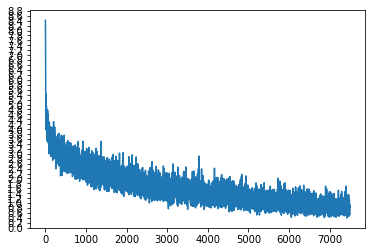

In [128]:
hidden_size = 256
encoder2 = Encoder(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoder(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)


trainIters_with_attention(encoder2, attn_decoder, 75000, print_every=1000,plot_every=10)

In [91]:
def evaluate_with_attention(encoder, decoder, sentence, max_length=max_length):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = torch.randn(1, 1, hidden_size)
        encoder_cell = torch.randn(1, 1, hidden_size)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei],
                                                     (encoder_hidden,encoder_cell))
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[Start_sentence_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, (decoder_hidden,decoder_cell), decoder_attention = decoder(
                decoder_input, (decoder_hidden,decoder_cell), encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == End_sentence_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [89]:
def evaluateRandomly_with_attention(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate_with_attention(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [129]:
evaluateRandomly_with_attention(encoder2, attn_decoder)

> i m having the time of my life .
= je m amuse comme un fou .
< j ai le meme age de temps . <EOS>

> you re welcome .
= avec plaisir .
< je t en prie . <EOS>

> i m at a friend s house .
= je suis chez un ami .
< je suis une amie a l universite . <EOS>

> i am alarmed by your irresponsible attitude .
= je suis inquiet de votre attitude irresponsable .
< je suis etonne par ton attitude irresponsable . <EOS>

> you re very good at this .
= tu es tres bon a ca .
< vous etes tres bonne a ceci . <EOS>

> you re not going are you ?
= vous n y allez pas si ?
< vous n y allez pas si ? <EOS>

> i m not good at pretending .
= je ne suis pas bon dans la simulation .
< je ne suis pas bon a la bonne . <EOS>

> he is very careful .
= il est tres prudent .
< il est tres prudent . <EOS>

> i m moving next month .
= je demenage le mois prochain .
< je m en vais le mois prochain . <EOS>

> they re out of their minds .
= ils ont perdu l esprit .
< elles ont perdu . <EOS>



(10 0%) 2.1630
(20 1%) 2.4904
(30 1%) 2.0316
(40 2%) 2.3919
(50 2%) 2.0484
(60 3%) 2.3225
(70 3%) 1.9921
(80 4%) 2.0890
(90 4%) 2.2262
(100 5%) 1.8781
(110 5%) 2.4431
(120 6%) 2.3928
(130 6%) 2.0829
(140 7%) 2.4325
(150 7%) 2.2963
(160 8%) 2.2665
(170 8%) 2.0137
(180 9%) 2.1840
(190 9%) 2.6133
(200 10%) 2.0180
(210 10%) 2.0369
(220 11%) 2.3372
(230 11%) 2.3304
(240 12%) 2.0695
(250 12%) 2.2369
(260 13%) 1.8577
(270 13%) 2.3726
(280 14%) 2.0047
(290 14%) 2.0562
(300 15%) 2.1734
(310 15%) 2.2937
(320 16%) 2.6430
(330 16%) 2.1598
(340 17%) 2.1096
(350 17%) 2.1251
(360 18%) 2.4609
(370 18%) 1.8963
(380 19%) 2.3325
(390 19%) 2.4775
(400 20%) 2.1907
(410 20%) 2.0352
(420 21%) 2.3031
(430 21%) 1.8685
(440 22%) 1.9820
(450 22%) 2.2597
(460 23%) 2.2898
(470 23%) 2.1533
(480 24%) 2.0097
(490 24%) 2.2802
(500 25%) 2.7746
(510 25%) 2.3484
(520 26%) 2.1732
(530 26%) 2.5932
(540 27%) 1.9440
(550 27%) 2.4554
(560 28%) 2.3005
(570 28%) 2.3038
(580 28%) 1.8288
(590 29%) 1.7535
(600 30%) 1.7311
(610 30%

<Figure size 432x288 with 0 Axes>

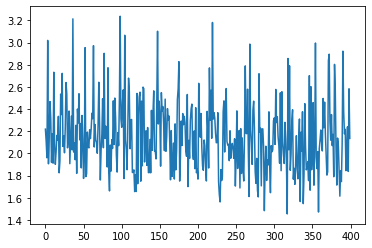

In [116]:
trainIters_with_attention(encoder2, attn_decoder, 2000, print_every=10,plot_every=5)

input = i am alarmed by your irresponsible attitude .
output = je suis votre par ton attitude . <EOS>
tensor([[4.2605e-04, 7.2381e-04, 3.7520e-04, 4.2058e-05, 9.5342e-01, 4.1974e-02,
         1.9608e-03, 6.3596e-06, 7.2486e-04, 3.5022e-04],
        [6.5358e-06, 2.4065e-05, 8.5689e-06, 2.8118e-05, 9.9988e-01, 3.3944e-06,
         5.4425e-06, 2.3545e-05, 1.8732e-05, 6.2883e-06],
        [5.3985e-07, 3.8779e-07, 5.2071e-08, 3.2002e-07, 9.9997e-01, 3.0947e-05,
         1.3410e-08, 2.9868e-09, 6.3365e-08, 1.2045e-07],
        [1.6953e-06, 6.9940e-06, 2.6024e-06, 2.0969e-06, 1.0226e-06, 9.4876e-01,
         5.1217e-02, 1.1844e-06, 1.7517e-06, 2.7854e-06],
        [6.6608e-06, 8.0744e-06, 4.8833e-05, 3.3909e-06, 4.3052e-09, 9.9578e-01,
         4.0964e-03, 3.1437e-05, 1.1076e-05, 9.7099e-06],
        [7.1982e-05, 3.6467e-04, 8.2290e-05, 7.0473e-04, 1.0036e-05, 6.9324e-04,
         6.0383e-01, 3.9366e-01, 1.5227e-04, 4.2730e-04],
        [1.5894e-03, 3.3288e-03, 2.5728e-03, 1.0430e-03, 1.1417e

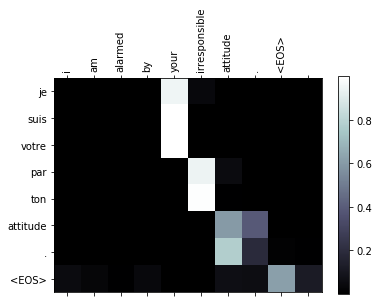

In [140]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    print(attentions)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate_with_attention(
        encoder2, attn_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("i am alarmed by your irresponsible attitude .")


In [138]:
torch.save(attn_decoder,'attndecoder')

c:\users\durantga\appdata\local\continuum\anaconda3\envs\courssup\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AttnDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
